In [51]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import re
import requests

import xarray as xr
import netCDF4

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def make_s3_client(credentials='/home/jovyan/.aws/credentials'):
    "Initialize s3 client."
    rhs = re.compile('^.* = (.*)$')
    with open(credentials) as c:
        dmy    = c.readline()
        key    = rhs.match(c.readline()).group(1)
        secret = rhs.match(c.readline()).group(1)
    return boto3.client('s3'
                        ,aws_access_key_id     = key
                        ,aws_secret_access_key = secret)

In [ ]:
s3_client = make_s3_client()

In [3]:
s3_client = boto3.client('s3',config=Config(signature_version=UNSIGNED))

In [8]:
s3_client = boto3.client('s3')

In [4]:
def get_s3_keys(bucket, s3_client, prefix = '', nmax = 10):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    done = False
    while not done:
        resp = s3_client.list_objects_v2(**kwargs)
        try:
            for obj in resp['Contents']:
                key = obj['Key']
                if key.startswith(prefix):
                    # print('key: ',key)
                    yield key
        except KeyError:
            print('Empty response from s3 for bucket %s with prefix %s'%(bucket,prefix))
            break

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break
            
        nmax = nmax - 1
        done = (nmax <= 0)

In [15]:
keys = get_s3_keys('daskhub-data',s3_client,prefix='')

In [ ]:
keys = get_s3_keys('noaa-goes17',s3_client,prefix='ABI-L1b-RadC/2018/240/00/OR_ABI-L1b-RadC-M3C01_G17_s20182400002156')

In [10]:
len(list(keys))

865

In [16]:
key_list = [key for key in keys]

In [17]:
key_list[0:10]

['GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4',
 'GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4',
 'GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4',
 'MODAPS/MOD05/MOD05_L2.A2019336.2300.061.2019337071951.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2300.061.2019337071951_stare.nc',
 'MODAPS/MOD05/MOD05_L2.A2019336.2305.061.2019337071951.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2305.061.2019337071951_stare.nc',
 'MODAPS/MOD05/MOD05_L2.A2019336.2310.061.2019337071934.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952.hdf',
 'MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc']

In [31]:
bucket_name='daskhub-data'
key=key_list[2]
print('getting: %s'%(key,))
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

getting: GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4


In [30]:
file_name = str(".".join(key.split('/')[-1].split('.')[0:]))
print('processing file "%s"'%(file_name,))
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

processing file "MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4"


OSError: [Errno -51] NetCDF: Unknown file format: b'MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4'

In [32]:
resp.content

b'<?xml version="1.0" encoding="UTF-8"?>\n<Error><Code>AccessDenied</Code><Message>Access Denied</Message><RequestId>CD30FDF966711863</RequestId><HostId>W4z3sRaC97cSvBSNAVNMN/UISZyH+GuaOMHcnlhipt3PNiu/n5u7YOWbhvjN5Pwgf0mw/wxniC4=</HostId></Error>'

In [ ]:
with open(file_name, 'wb') as f:
    s3.download_fileobj('daskhub-data', key, f)

In [33]:
from io import BytesIO

In [34]:
file = BytesIO()

In [40]:
s3_client.download_fileobj('daskhub-data',key,file)
# file.name=file_name
# file.seek(0)

In [42]:
nc4_ds = netCDF4.Dataset(file)
# store  = xr.backends.NetCDF4DataStre(nc4_ds)
# DS     = xr.open_dataset(store)

FileNotFoundError: [Errno 2] No such file or directory: b'<_io.BytesIO object at 0x7fed03ceb770>'

In [44]:
file.close()

In [49]:
s3 = boto3.resource('s3',region_name='us-east-1')
bucket = s3.Bucket('daskhub-data')
obj    = bucket.Object(key)
response = obj.get()
nc4_ds = netCDF4.Dataset(file_name,memory=response['Body'].read())

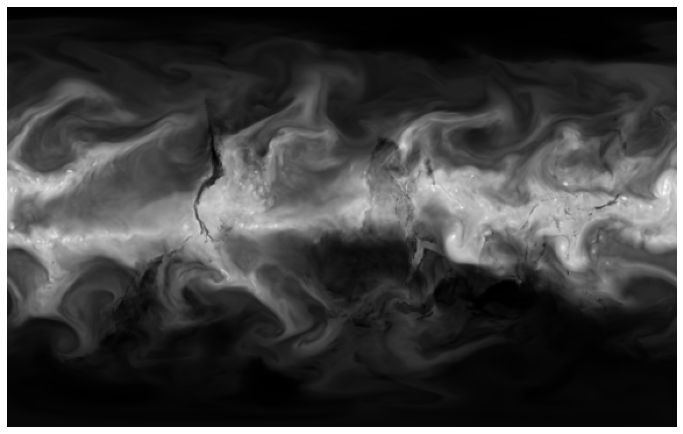

In [55]:
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.TQV[0,:,:], cmap='gray')
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')

In [53]:
DS.keys()

KeysView(<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 2019-12-26T00:30:00 ... 2019-12-26T23:30:00
Data variables:
    CLDPRS    (time, lat, lon) float32 ...
    CLDTMP    (time, lat, lon) float32 ...
    DISPH     (time, lat, lon) float32 ...
    H1000     (time, lat, lon) float32 ...
    H250      (time, lat, lon) float32 ...
    H500      (time, lat, lon) float32 ...
    H850      (time, lat, lon) float32 ...
    OMEGA500  (time, lat, lon) float32 ...
    PBLTOP    (time, lat, lon) float32 ...
    PS        (time, lat, lon) float32 ...
    Q250      (time, lat, lon) float32 ...
    Q500      (time, lat, lon) float32 ...
    Q850      (time, lat, lon) float32 ...
    QV10M     (time, lat, lon) float32 ...
    QV2M      (time, lat, lon) float32 ...
    SLP       (time, 